### Import Dependencies

In [35]:
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Initialize Gait Table

In [36]:
def gait_df_init():
       gait_df = pd.read_csv("csv-input/gait-table.csv", index_col=0)
       gait_df.fillna(0)

       gait_feats = [
              "Cadence_L", "Cadence_R", 
              "DblSupport_L", "DblSupport_R", 
              "ElevMidswing_L", "ElevMidswing_R", 
              "CycleDur_L", "CycleDur_R",
              "Speed_L", "Speed_R",
              "Circumdxn_L", "Circumdxn_R",
              "HSAngle_L", "HSAngle_R",
              "TOffAngle_L", "TOffAngle_R",
              "SglSupport_L", "SglSupport_R", 
              "Stance_L", "Stance_R", 
              "StepDur_L", "StepDur_R",
              "StrideLength_L", "StrideLength_R", 
              "Swing_L", "Swing_R",
              "TermDblSupport_L", "TermDblSupport_R", 
              "ToeOutAngle_L", "ToeOutAngle_R", 
              "LumbarCorROM", "LumbarSagROM", "LumbarTransvROM",
              "TrunkCorROM", "TrunkSagROM", "TrunkTransvROM", 
              "ArmSwingVel_L", "ArmSwingVel_R", "ArmROM_L", "ArmROM_R"
       ]

       # Group left and right features
       feat_dict = {}
       updated_gait_feats = []
       for feat in gait_feats:
              if "_" in feat:
                     group, side = feat.split("_")
                     if group not in feat_dict:
                            feat_dict[group] = ["", ""]
                     feat_dict[group][0 if side == "L" else 1] = feat
              else:
                     updated_gait_feats.append(feat)

       # Calculate mean between both left and right for feature, append to gait table
       for group, [left, right] in feat_dict.items():
              gait_df[group + "_Avg"] = gait_df[[left, right]].mean(axis=1)

       return gait_df

### Box Plot

- Stride Length and Speed
    - Each subject’s stride length/speed is calculated as the average across all of that subject's gait cycles
    - Three box plots (walk, walkAuditory, walkVisual) for each category of subject (hc, nofog, fog)

In [37]:
def box_plot(gait_df):
    # ----- Stride Length -----

    subject_stridelength = gait_df[["Subject", "group", "Condition", "Cycle_Index", "StrideLength_Avg"]].fillna(0)
    # Calculate the average stride length across all gait cycles for each subject
    subject_average_stridelength = subject_stridelength[["Subject", "group", "Condition", "StrideLength_Avg"]].groupby(["Subject", "group", "Condition"])["StrideLength_Avg"].mean().reset_index()

    # Plot
    plt.figure(figsize=(15, 10))  # Default for all images
    sns.boxplot(x="group", y="StrideLength_Avg", hue="Condition", data=subject_average_stridelength, palette="deep")

    # Customize plot
    plt.title("Distribution of Average Stride Length Across Groups and Conditions")
    plt.xlabel("Group")
    plt.ylabel("Average Stride Length")

    plt.savefig("images/stridelength_box_plot.png")
    plt.clf()

    # ----- Speed -----

    subject_speed = gait_df[["Subject", "group", "Condition", "Cycle_Index", "Speed_Avg"]]
    # Calculate the average speed across all gait cycles for each subject
    subject_average_speed = subject_speed[["Subject", "group", "Condition", "Speed_Avg"]].groupby(["Subject", "group", "Condition"])["Speed_Avg"].mean().reset_index()

    # Plot
    sns.boxplot(x="group", y="Speed_Avg", hue="Condition", data=subject_average_speed, palette="deep")

    # Customize plot
    plt.title("Distribution of Average Speed Across Groups and Conditions")
    plt.xlabel("Group")
    plt.ylabel("Average Speed")

    plt.savefig("images/speed_box_plot.png")
    plt.show()

### Scatter Plot

- Stride Length
    - Two scatter plots (NoFOG, FOG) for each condition (walk, walkAuditory, and walkVisual)
    - Severity vs. Improvement (x-axis is Severity, y-axis is Improvement)
    - How is Improvement measured?
        - Percent change (higher percent change means more improvement)
        - (Final - Initial)/Initial * 100% (so that measurement is standardized across subjects)

In [38]:
def scatter_plot(gait_df):
    # ----- Stride Length -----

    subject_stridelength = gait_df[["Subject", "group", "Condition", "UPDRS III TOTAL:", "Cycle_Index", "StrideLength_Avg"]].fillna(0)
    # Calculate the average stride length across all gait cycles for each subject
    subject_average_stridelength = subject_stridelength[["Subject", "group", "Condition", "UPDRS III TOTAL:", "StrideLength_Avg"]].groupby(["Subject", "group", "UPDRS III TOTAL:", "Condition"])["StrideLength_Avg"].mean().reset_index()
    subject_average_walk_stridelength = subject_average_stridelength.loc[subject_average_stridelength["Condition"] == "walk"].set_index("Subject")["StrideLength_Avg"].to_dict()

    # Calculate improvement

    # Parkinson's disease - NoFOG
    nofog_average_stridelength = subject_average_stridelength.loc[subject_average_stridelength["group"] == "nofog"].reset_index(drop=True)
    nofog_average_stridelength = nofog_average_stridelength.loc[~(nofog_average_stridelength["Subject"] == "sub-PD33")].reset_index(drop=True)  # Exclude sub-PD33, no walk run
    nofog_average_stridelength["Improvement"] = nofog_average_stridelength.apply(lambda row: (row["StrideLength_Avg"] - subject_average_walk_stridelength[row["Subject"]])/(subject_average_walk_stridelength[row["Subject"]]) * 100, axis=1)

    # Plot
    plt.figure(figsize=(15, 10))  # Default for all images
    sns.scatterplot(x="UPDRS III TOTAL:", y="Improvement", hue="Condition", data=nofog_average_stridelength)

    # Customize plot
    plt.title("Severity vs. Improvement in NoFOG Parkinson's Patients")
    plt.xlabel("Severity")
    plt.ylabel("Improvement")

    plt.savefig("images/nofog_stridelength_scatter_plot.png")
    plt.show()

    # Parkinson's disease - FOG
    fog_average_stridelength = subject_average_stridelength.loc[subject_average_stridelength["group"] == "fog"].reset_index(drop=True)
    fog_average_stridelength["Improvement"] = fog_average_stridelength.apply(lambda row: (row["StrideLength_Avg"] - subject_average_walk_stridelength[row["Subject"]])/(subject_average_walk_stridelength[row["Subject"]]) * 100, axis=1)

    # Plot
    plt.figure(figsize=(15, 10))  # Default for all images
    sns.scatterplot(x="UPDRS III TOTAL:", y="Improvement", hue="Condition", data=fog_average_stridelength)

    # Customize plot
    plt.title("Severity vs. Improvement in FOG Parkinson's Patients")
    plt.xlabel("Severity")
    plt.ylabel("Improvement")

    plt.savefig("images/fog_stridelength_scatter_plot.png")
    plt.show()

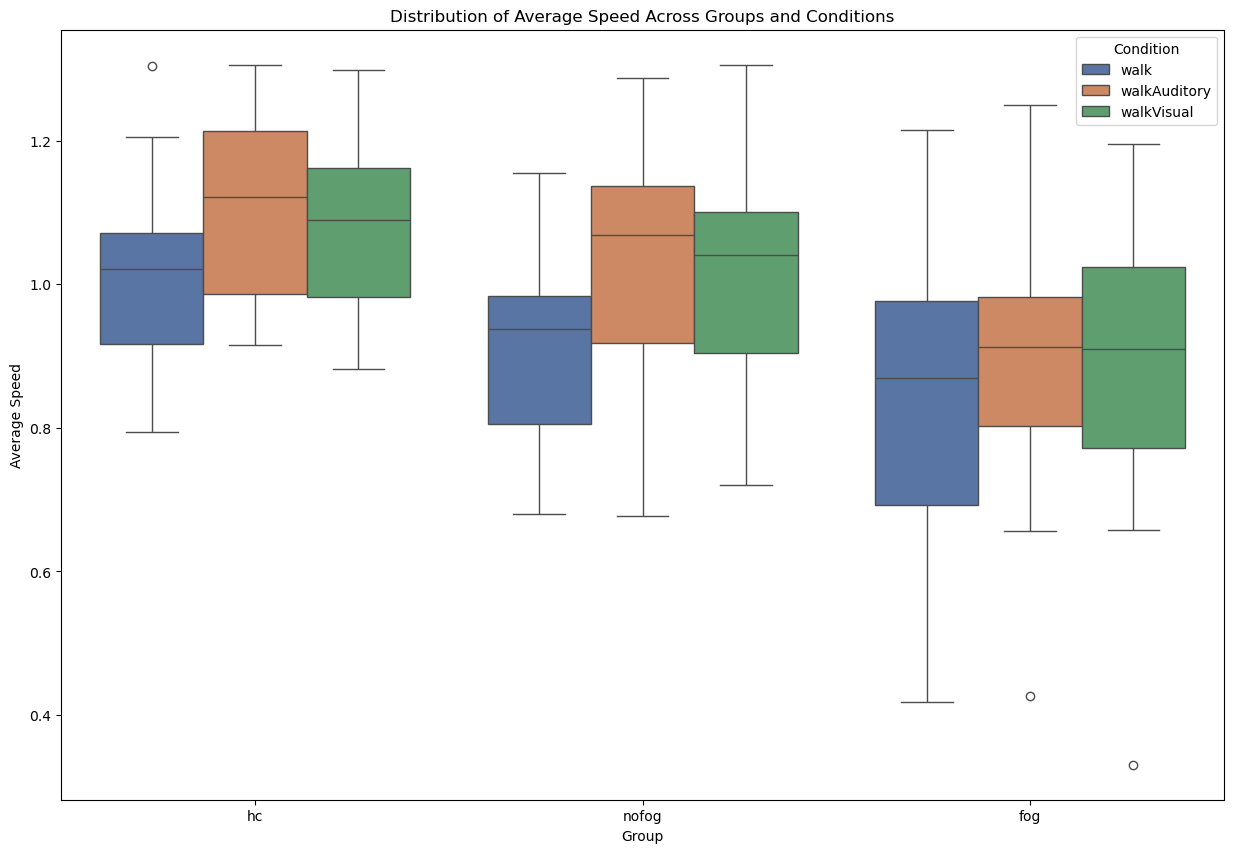

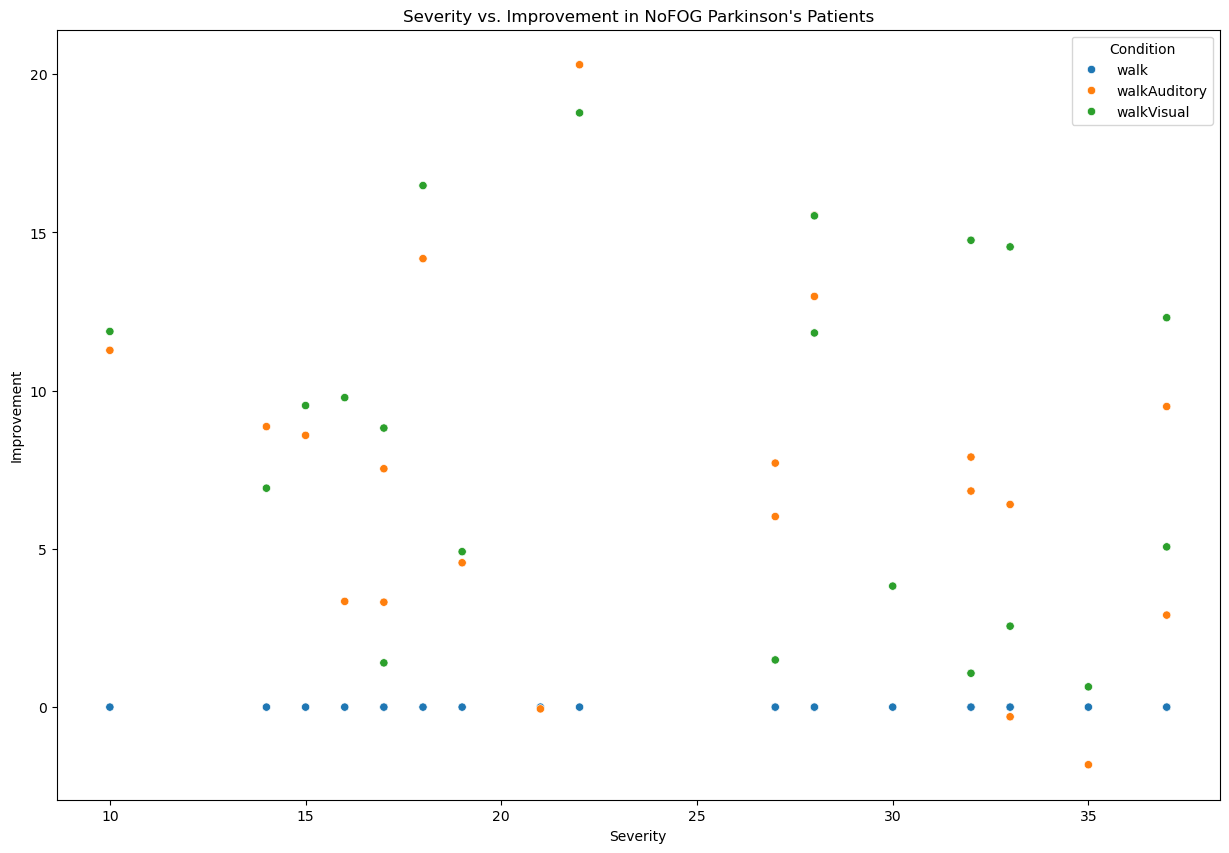

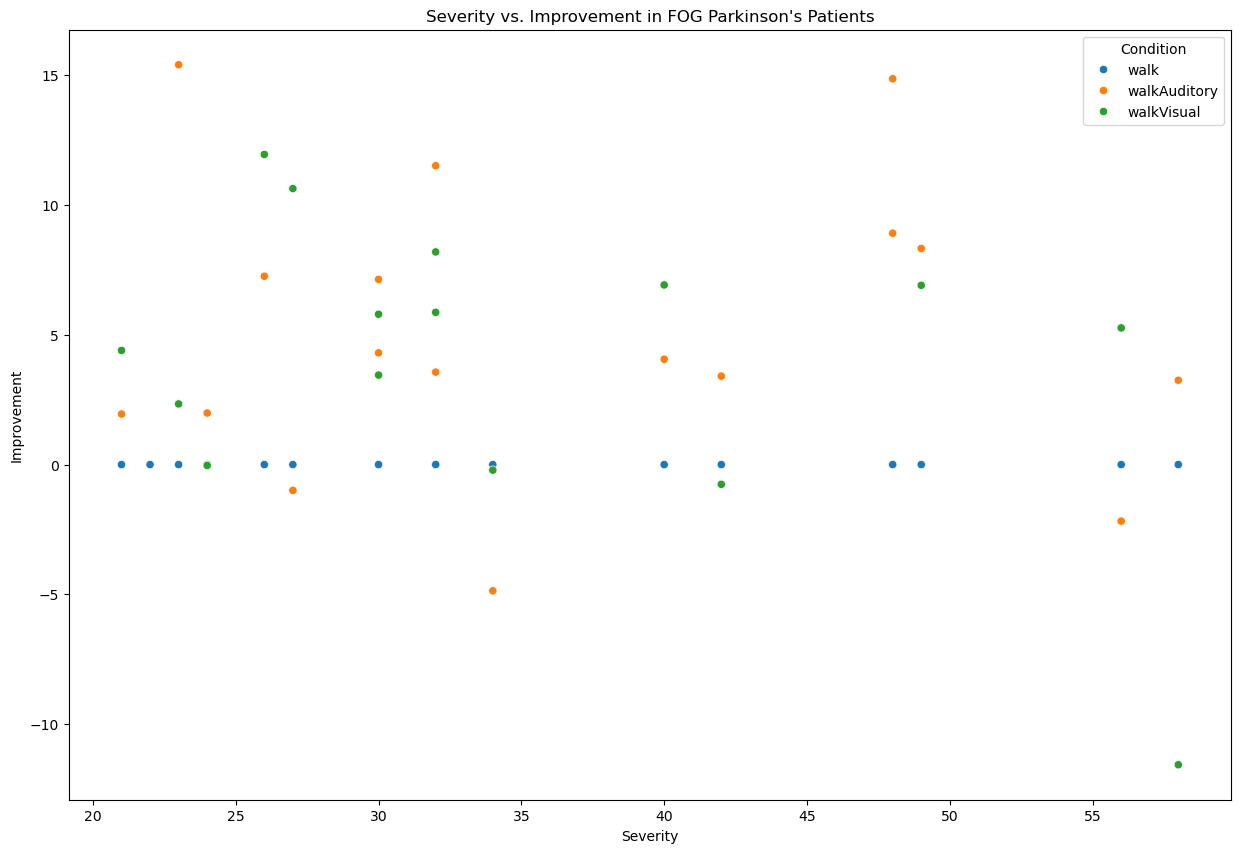

In [39]:
def main():
    # Initialize gait table
    gait_df = gait_df_init()

    # Box plot
    box_plot(gait_df)

    # Scatter plot
    scatter_plot(gait_df)


if __name__ == "__main__":
    main()
